In [1]:
# Global parameters
EPOCHS = 10
BATCH_SIZE = 8
WORKERS = 4
IMAGE_SIZE = 320

# Custom Train

In [49]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training import transforms
from super_gradients.training.datasets import data_augmentation
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val,
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random


# Download dataset

In [3]:
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f'Download file {save_name}')
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-lenght',0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print(f'File {save_name} already exists')

download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    '/datasets/hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

In [4]:
# unzip the data file
def unzip(zip_file=None, dst=None):
    try:
        with zipfile.ZipFile(zip_file) as zip_ref:
            zip_ref.extractall(dst)
            print("Extracted all")
    except:
        print('invalid file')
unzip('/datasets/hituav-a-highaltitude-infrared-thermal-dataset.zip',
      '/datasets')

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File /datasets/hituav-a-highaltitude-infrared-thermal-dataset.zip already exists


# Dataset Setup

In [5]:
ROOT_DIR = '/datasets/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'

val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'

test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'

classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [6]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir': train_imgs_dir,
    'train_labels_dir': train_labels_dir,
    'val_images_dir': val_imgs_dir,
    'val_labels_dir': val_labels_dir,
    'test_images_dir': test_imgs_dir,
    'test_labels_dir': test_labels_dir,
    'classes':classes,
}

# Visualize Ground Truth Images

In [7]:
colors = np.random.uniform( 0, 255, size=(len(classes), 3) )

In [8]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0] - bboxes[2]/2, bboxes[1] - bboxes[3]/2
    xmax, ymax = bboxes[0] + bboxes[2]/2, bboxes[1] + bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width = image.shape[:2]
    # lw = max(round(sum(image.shape / 2 * 0.003)), 2) # line width
    lw = max(round( sum(image.shape) / 2 * 0.003 ),2)
    tf = max(lw - 1, 1)
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = colors[classes.index(class_name)]

        cv2.rectangle(image, p1, p2, color=color, thickness=lw, lineType=cv2.LINE_AA)

        # for filled rectangle
        w, h = cv2.getTextSize(class_name,
                               0,
                               fontScale=lw/3,
                               thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        # p2 = p1[0] + w, (p1[1] - h - 3 if outside else p1[1] + h + 3)

        cv2.rectangle(image, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)
        cv2.putText(image,
                    class_name,
                    (p1[0], p1[1] -5 if outside else p1[1] + h + 2),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=lw/3.5,
                    color=(255,255,255),
                    thickness=tf,
                    lineType=cv2.LINE_AA
                )
    return image

In [10]:
# Function to plot images with bounding boxes.
def plot(image_path, label_path, num_samples, viz_grid=[2,2]):
    all_training_images = glob.glob(image_path + '/*')
    all_training_labels = glob.glob(label_path + '/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list( zip(all_training_images, all_training_labels) )
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list( all_training_images ), list( all_training_labels )

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images
    
    plt.figure(figsize=(15,12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        # print( len(bboxes) )
        # result_image = plot_box(image, bboxes, labels)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(viz_grid[0], viz_grid[1], i+1) # visualize 2x2 grid of images
        plt.imshow(result_image[:,:,::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Extracted all


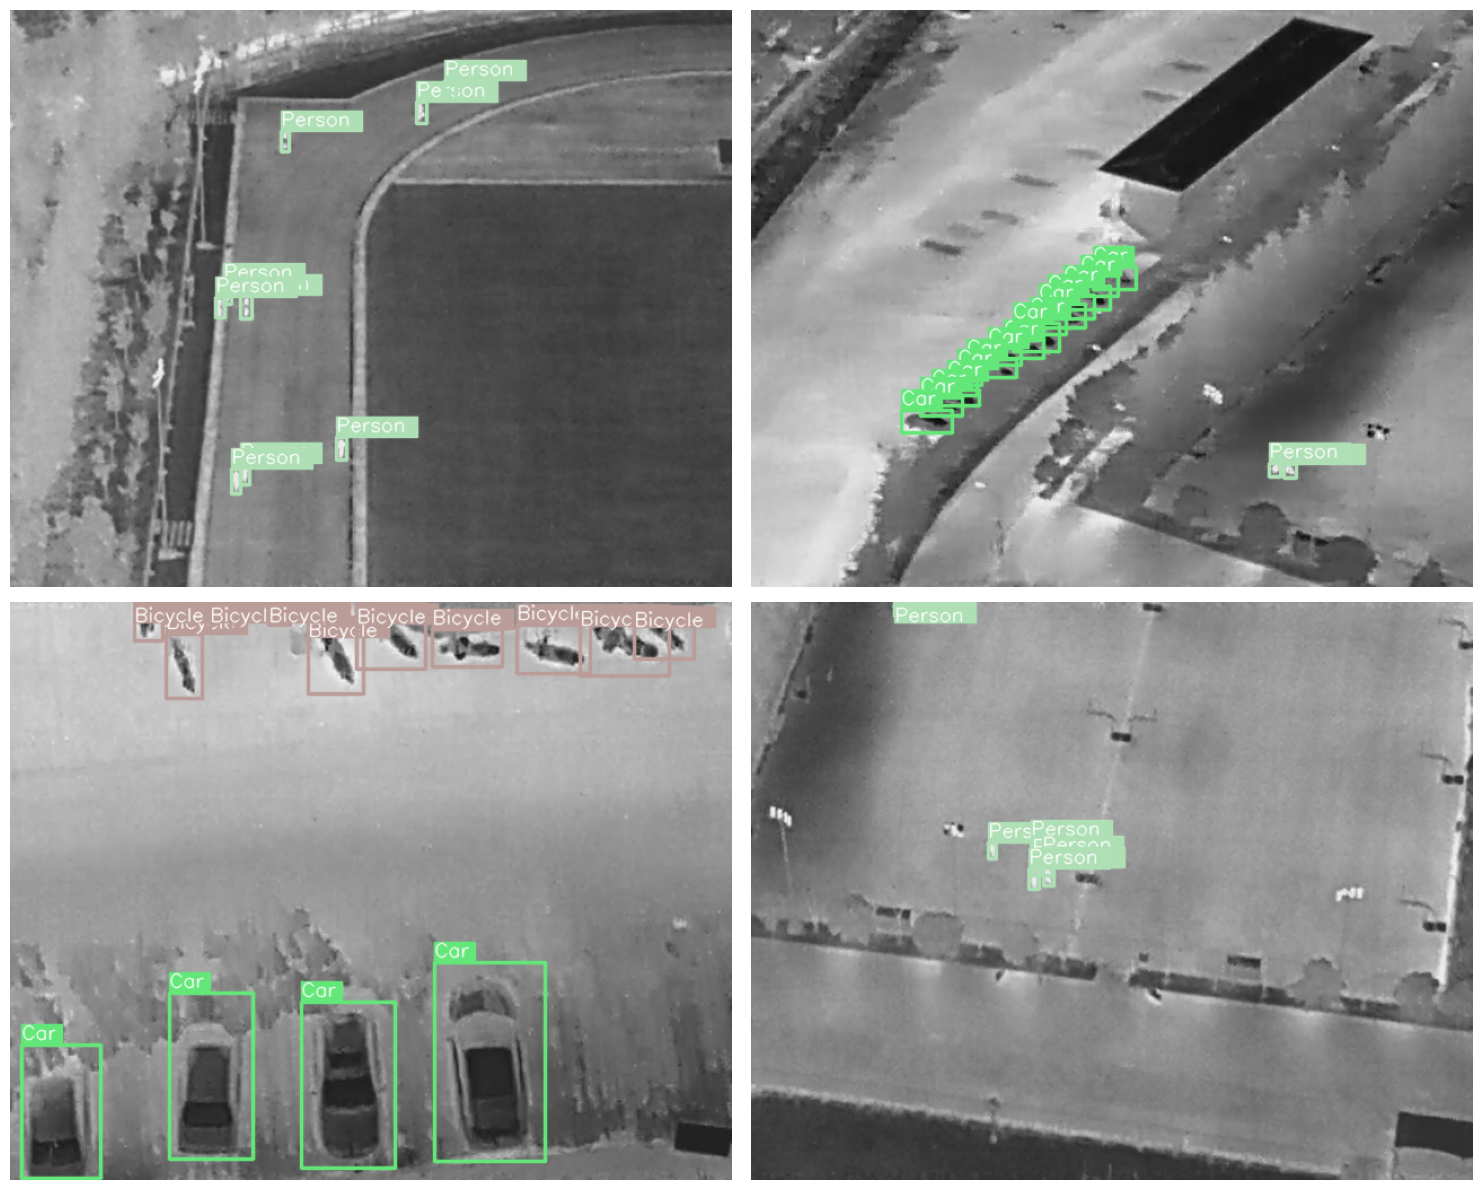

In [11]:
# Visualize a few training images
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4
)

# Data Preparation

In [50]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir':dataset_params['data_dir'],
        'images_dir':dataset_params['train_images_dir'],
        'labels_dir':dataset_params['train_labels_dir'],
        'classes':dataset_params['classes'],
        'input_dim': [IMAGE_SIZE, IMAGE_SIZE],
    },
    dataloader_params={
        'shuffle': True,
        'batch_size': BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir':dataset_params['data_dir'],
        'images_dir':dataset_params['val_images_dir'],
        'labels_dir':dataset_params['val_labels_dir'],
        'classes':dataset_params['classes'],
        'input_dim': [IMAGE_SIZE, IMAGE_SIZE],
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations:  77%|███████▋  | 1555/2008 [00:00<00:00, 7777.95it/s]

Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 7960.25it/s]


# Transforms and Augmentations

In [53]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (320, 320), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (320, 320), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (320, 320), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [19]:
val_data.dataset.transforms

[DetectionPaddedRescale('swap': (2, 0, 1), 'input_dim': (320, 320), 'max_targets': 50, 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.xyxy.XYXYCoordinateFormat object at 0x7fd3a05fd790>), ('labels', name=labels length=1)]), 'output_format': OrderedDict([('labels', name=labels length=1), ('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.cxcywh.CXCYWHCoordinateFormat object at 0x7fd3a05a4790>)]), 'max_targets': 50, 'min_bbox_edge_size': 1, 'input_dim': (320, 320), 'targets_format_converter': <super_gradients.training.datasets.data_formats.format_converter.ConcatenatedTensorFormatConverter object at 0x7fd38814d640>)]

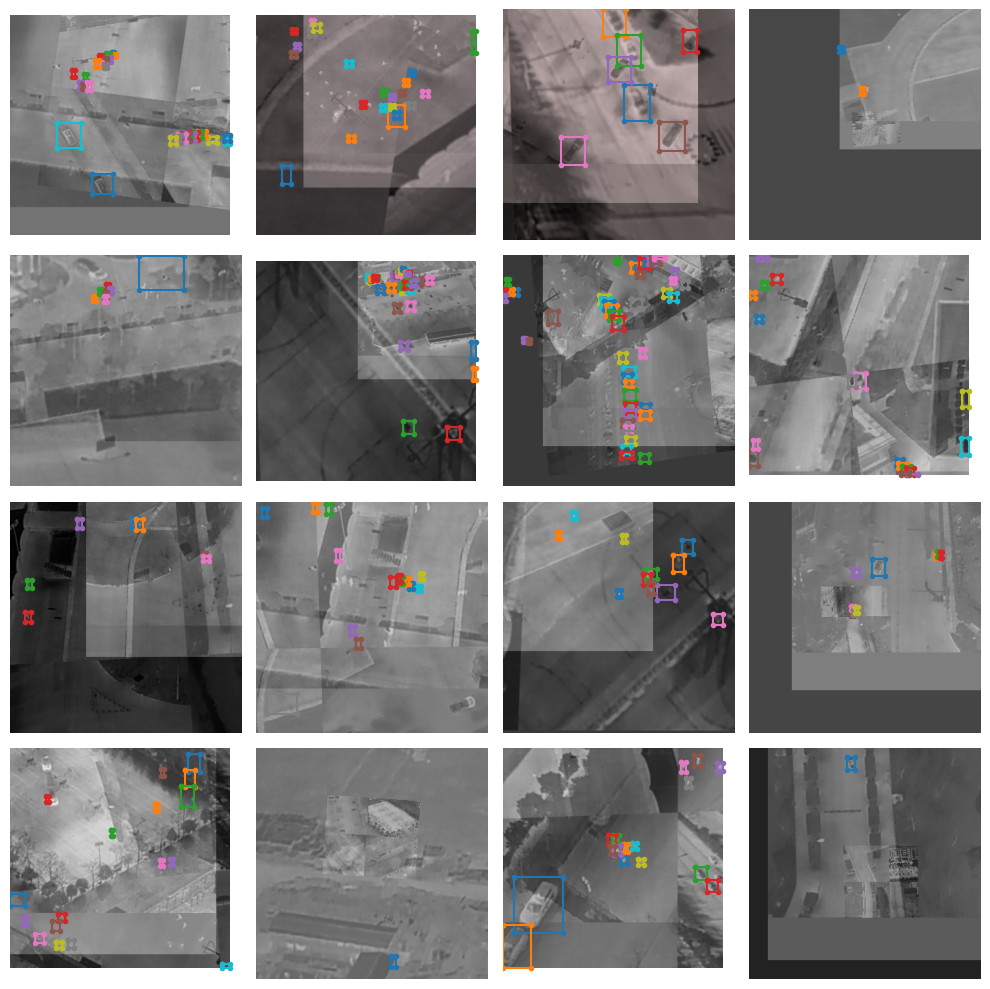

In [54]:
train_data.dataset.plot(plot_transformed_data=True)

# Train Parameters

In [15]:
train_params = {
    'silent_mode': False,
    'sync_bn': True,
    'average_best_models': True,
    'warmup_mode':'linear_epoch_step',
    'warmup_initial_lr': 1e-6,
    'lr_warmup_epochs':3,
    'initial_lr':2e-3,
    'lr_mode':'cosine',
    'cosine_final_lr_ratio':0.1,
    'optimizer':'AdamW',
    'optimizer_params':{'weight_decay':0.0001},
    'zero_weight_decay_on_bias_and_bn': False,
    'ema': True,
    'ema_params': {'decay':0.9997, 'decay_type': 'threshold'},
    'max_epochs': EPOCHS,
    'mixed_precision':False,
    'loss': PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    'valid_metrics_list':[
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7,
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7,
            )
        )
    ],
    'metric_to_watch':'mAP@0.50:0.95',
    'greater_metric_to_watch_is_better': True,
}

In [16]:
models_to_train = [
    # models.Models.YOLO_NAS_S,
    models.Models.PP_YOLOE_S
]

In [17]:
CHECKPOINT_DIR = '/workspace/ckps'

# Model Training

In [18]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train,
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(model_to_train,
                       num_classes=len(dataset_params['classes']),
                       pretrained_weights='coco'
                       )
    
    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

The console stream is now moved to /workspace/ckps/ppyoloe_s/console_Jun18_06_36_42.txt


[2023-06-18 06:36:43] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         251        (len(train_loader))
    - Gradient updates per epoch:   251        (len(train_loader) / batch_accumulate)

[2023-06-18 06:36:43] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validation epoch 0: 100%|██████████| 36/36 [00:03<00:00, 10.96it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.7441
│   ├── Ppyoloeloss/loss_cls = 2.3591
│   ├── Ppyoloeloss/loss_dfl = 0.9977
│   └── Ppyoloeloss/loss_iou = 0.3544
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0
    ├── Map@0.50:0.95 = 0.0
    ├── Ppyoloeloss/loss = 3.7448
    ├── Ppyoloeloss/loss_cls = 2.643
    ├── Ppyoloeloss/loss_dfl = 0.7799
    ├── Ppyoloeloss/loss_iou = 0.2847
    ├── Precision@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-06-18 06:37:23] INFO - base_sg_logger.py - Checkpoint saved in /workspace/ckps/ppyoloe_s/ckpt_best.pth
[2023-06-18 06:37:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 4.1409133899605877e-08
Validation epoch 1: 100%|██████████| 36/36 [00:04<00:00,  7.63it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.4484
│   │   ├── Best until now = 3.7441 (↘ -1.2957)
│   │   └── Epoch N-1      = 3.7441 (↘ -1.2957)
│   ├── Ppyoloeloss/loss_cls = 1.3192
│   │   ├── Best until now = 2.3591 (↘ -1.0399)
│   │   └── Epoch N-1      = 2.3591 (↘ -1.0399)
│   ├── Ppyoloeloss/loss_dfl = 0.7958
│   │   ├── Best until now = 0.9977 (↘ -0.2019)
│   │   └── Epoch N-1      = 0.9977 (↘ -0.2019)
│   └── Ppyoloeloss/loss_iou = 0.2925
│       ├── Best until now = 0.3544 (↘ -0.0619)
│       └── Epoch N-1      = 0.3544 (↘ -0.0619)
└── Validation
    ├── F1@0.50 = 0.0427
    │   ├── Best until now = 0.0    (↗ 0.0427)
    │   └── Epoch N-1      = 0.0    (↗ 0.0427)
    ├── F1@0.50:0.95 = 0.0221
    │   ├── Best until now = 0.0    (↗ 0.0221)
    │   └── Epoch N-1      = 0.0    (↗ 0.0221)
    ├── Map@0.50 = 0.2416
    │   ├── Best until now = 0.0    (↗ 0.2416)
    │   └── Epoch N-1      = 0.0    (↗ 0.2416)
    ├── Map@0.50:0.95 = 0.1152
    │   ├── Best until now 

[2023-06-18 06:38:03] INFO - base_sg_logger.py - Checkpoint saved in /workspace/ckps/ppyoloe_s/ckpt_best.pth
[2023-06-18 06:38:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11515309661626816
Validation epoch 2: 100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.0086
│   │   ├── Best until now = 2.4484 (↘ -0.4398)
│   │   └── Epoch N-1      = 2.4484 (↘ -0.4398)
│   ├── Ppyoloeloss/loss_cls = 0.9612
│   │   ├── Best until now = 1.3192 (↘ -0.358)
│   │   └── Epoch N-1      = 1.3192 (↘ -0.358)
│   ├── Ppyoloeloss/loss_dfl = 0.7402
│   │   ├── Best until now = 0.7958 (↘ -0.0556)
│   │   └── Epoch N-1      = 0.7958 (↘ -0.0556)
│   └── Ppyoloeloss/loss_iou = 0.2709
│       ├── Best until now = 0.2925 (↘ -0.0216)
│       └── Epoch N-1      = 0.2925 (↘ -0.0216)
└── Validation
    ├── F1@0.50 = 0.0603
    │   ├── Best until now = 0.0427 (↗ 0.0177)
    │   └── Epoch N-1      = 0.0427 (↗ 0.0177)
    ├── F1@0.50:0.95 = 0.0314
    │   ├── Best until now = 0.0221 (↗ 0.0093)
    │   └── Epoch N-1      = 0.0221 (↗ 0.0093)
    ├── Map@0.50 = 0.3024
    │   ├── Best until now = 0.2416 (↗ 0.0608)
    │   └── Epoch N-1      = 0.2416 (↗ 0.0608)
    ├── Map@0.50:0.95 = 0.144
    │   ├── Best until now = 0

[2023-06-18 06:38:44] INFO - base_sg_logger.py - Checkpoint saved in /workspace/ckps/ppyoloe_s/ckpt_best.pth
[2023-06-18 06:38:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.14397236704826355
Validation epoch 3: 100%|██████████| 36/36 [00:05<00:00,  6.98it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.9541
│   │   ├── Best until now = 2.0086 (↘ -0.0545)
│   │   └── Epoch N-1      = 2.0086 (↘ -0.0545)
│   ├── Ppyoloeloss/loss_cls = 0.9256
│   │   ├── Best until now = 0.9612 (↘ -0.0357)
│   │   └── Epoch N-1      = 0.9612 (↘ -0.0357)
│   ├── Ppyoloeloss/loss_dfl = 0.7286
│   │   ├── Best until now = 0.7402 (↘ -0.0116)
│   │   └── Epoch N-1      = 0.7402 (↘ -0.0116)
│   └── Ppyoloeloss/loss_iou = 0.2657
│       ├── Best until now = 0.2709 (↘ -0.0052)
│       └── Epoch N-1      = 0.2709 (↘ -0.0052)
└── Validation
    ├── F1@0.50 = 0.059
    │   ├── Best until now = 0.0603 (↘ -0.0014)
    │   └── Epoch N-1      = 0.0603 (↘ -0.0014)
    ├── F1@0.50:0.95 = 0.0322
    │   ├── Best until now = 0.0314 (↗ 0.0007)
    │   └── Epoch N-1      = 0.0314 (↗ 0.0007)
    ├── Map@0.50 = 0.345
    │   ├── Best until now = 0.3024 (↗ 0.0427)
    │   └── Epoch N-1      = 0.3024 (↗ 0.0427)
    ├── Map@0.50:0.95 = 0.1692
    │   ├── Best until now 

[2023-06-18 06:39:26] INFO - base_sg_logger.py - Checkpoint saved in /workspace/ckps/ppyoloe_s/ckpt_best.pth
[2023-06-18 06:39:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16919906437397003
Train epoch 4:  93%|█████████▎| 234/251 [00:33<00:02,  7.23it/s, PPYoloELoss/loss=1.88, PPYoloELoss/loss_cls=0.89, PPYoloELoss/loss_dfl=0.716, PPYoloELoss/loss_iou=0.254, gpu_mem=1.31] 

Train epoch 4:  93%|█████████▎| 234/251 [00:33<00:02,  6.94it/s, PPYoloELoss/loss=1.88, PPYoloELoss/loss_cls=0.89, PPYoloELoss/loss_dfl=0.716, PPYoloELoss/loss_iou=0.254, gpu_mem=1.31]
[2023-06-18 06:40:00] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2023-06-18 06:40:00] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2023-06-18 06:40:00] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [ ]:
# from super_gradients.training.datasets import YoloDarknetFormatDetectionDataset
# dataset = YoloDarknetFormatDetectionDataset(data_dir = '/datasets/hard_hat/train',
#                                             images_dir = '/datasets/hard_hat/train',
#                                             labels_dir = '/datasets/hard_hat/train',
#                                             classes = ['head', 'helmet', 'person'],
#                                             )